# Compare Linearized Prior

In [1]:
import numpy as np
import os
import wandb
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.config import default_float
from gpflow.likelihoods import Gaussian

from docs.sde.sde_exp_utils import generate_dw_data
from markovflow.sde.sde import PriorDoubleWellSDE
from markovflow.models.cvi_sde import SDESSM
from markovflow.models.vi_sde import VariationalMarkovGP

from IPython.display import clear_output


2022-07-12 16:32:35.236482: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-12 16:32:35.236505: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-12 16:32:36.460548: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-12 16:32:36.461156: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-12 16:32:36.488555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 16:32:36.488876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties

In [2]:
os.environ['WANDB_MODE'] = 'offline'
wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [3]:
# Set seed
tf.random.set_seed(12)
np.random.seed(12)

## Parameters

In [4]:
DTYPE = default_float()
q = 1.2
x0 = 1.
t0 = 0.
t1 = 30.
dt = 0.01
noise_var = 0.01

## Generate Data

In [5]:
obs_vals, obs_grid, latent_process, time_grid, _, _, _ = generate_dw_data(q=q, x0=x0, t0=t0, t1=t1,
                                                                            simulation_dt=dt,
                                                                            noise_stddev=np.sqrt(noise_var),
                                                                            n_observations=100,
                                                                            dtype=DTYPE)

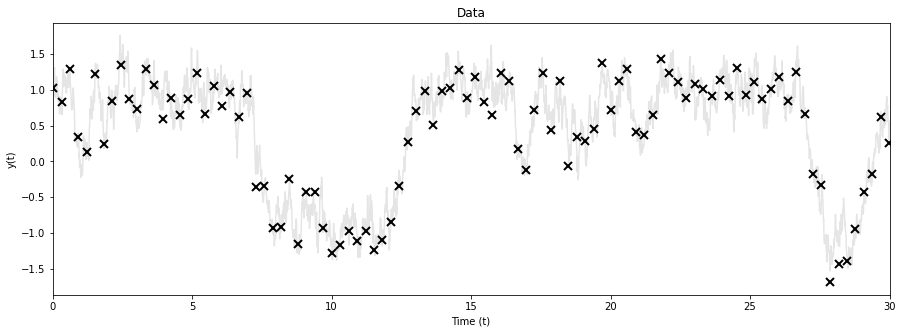

In [6]:
plt.rcParams["figure.figsize"] = [15, 5]
plt.plot(time_grid, tf.reshape(latent_process, (-1)), label="Latent Process", alpha=0.2, color="gray")
plt.plot(obs_grid.numpy().reshape(-1), obs_vals.numpy().reshape(-1), 'kx', ms=8, mew=2, label="Observations (Y)")
plt.xlabel("Time (t)")
plt.ylabel("y(t)")
plt.xlim([t0, t1])
plt.title("Data")
plt.show()

In [7]:
# Prior SDE
true_q = q * tf.ones((1, 1), dtype=DTYPE)
prior_sde = PriorDoubleWellSDE(q=true_q, initial_a_val=4., initial_c_val=1.)

# likelihood
likelihood = Gaussian(noise_var)

obs_data = (obs_grid, tf.squeeze(obs_vals, axis=0))

## SDE-SSM

In [18]:
ssm_model = SDESSM(input_data=obs_data, prior_sde=prior_sde, grid=time_grid, likelihood=likelihood, learning_rate=.9)

# Set initial statistics and posterior path
ssm_model.initial_mean = 1. + 0. * ssm_model.initial_mean
ssm_model.initial_chol_cov = .5 + 0. * ssm_model.initial_chol_cov

ssm_model.fx_mus = tf.reshape(latent_process, ssm_model.fx_mus.shape)
ssm_model.fx_covs = .1 + 0. * ssm_model.fx_covs

ssm_model.linearization_pnts = (tf.identity(ssm_model.fx_mus[:, :-1, :]), 
                                tf.identity(ssm_model.fx_covs[:, :-1, :, :]))
ssm_model._linearize_prior()

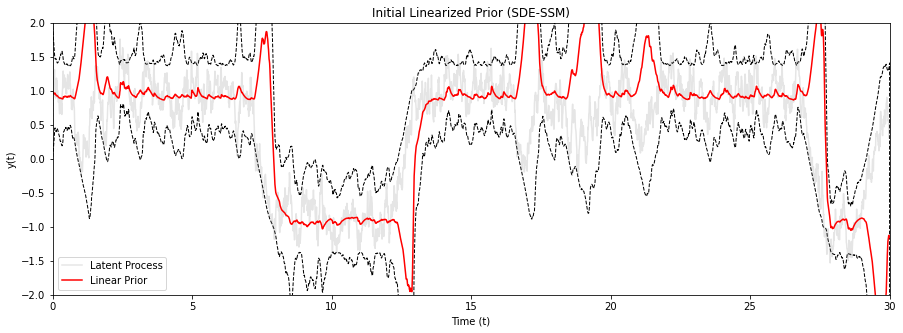

In [19]:
ssm_lin_prior_marginals = ssm_model.dist_p_ssm.marginals

ssm_lin_prior_m = ssm_lin_prior_marginals[0].numpy().reshape(-1)
ssm_lin_prior_S = ssm_lin_prior_marginals[1].numpy().reshape(-1)

plt.rcParams["figure.figsize"] = [15, 5]
plt.plot(time_grid, tf.reshape(latent_process, (-1)), label="Latent Process", alpha=0.2, color="gray")

plt.plot(time_grid, ssm_lin_prior_m, label="Linear Prior", color="red")
plt.fill_between(
            time_grid,
            y1=(ssm_lin_prior_m - 2 * np.sqrt(ssm_lin_prior_S)),
            y2=(ssm_lin_prior_m + 2 * np.sqrt(ssm_lin_prior_S)),
            edgecolor="black",
            facecolor=(0, 0, 0, 0.),
            linestyle='dashed'
        )

plt.xlabel("Time (t)")
plt.ylabel("y(t)")
plt.xlim([t0, t1])
plt.ylim([-2 ,2])
plt.title("Initial Linearized Prior (SDE-SSM)")
plt.legend()
plt.show()

In [10]:
# Perform inference

ssm_model.run()

SSM: Starting ELBO -1351.0826532666201;
SSM: ELBO -194.4685894542438!!!
SSM: ELBO after linearization -138.72966332408944!!!
SSM: ELBO -106.04354341320334!!!
SSM: ELBO after linearization -54.70868783827958!!!
SSM: ELBO -61.9525383109218!!!
SSM: ELBO after linearization -61.17014577269342!!!
SSM: ELBO -61.807702056445386!!!
SSM: ELBO after linearization -59.138651519753076!!!
SSM: ELBO -59.931036035068466!!!
SSM: ELBO after linearization -60.567012702448245!!!
SSM: ELBO decreasing! Decaying LR!!!
SSM: ELBO -61.38690046631687!!!
SSM: ELBO after linearization -59.29020056411287!!!
SSM: Sites Converged!!!


(ListWrapper([-1351.0826532666201, -194.4685894542438, -138.72966332408944, -106.04354341320334, -54.70868783827958, -61.9525383109218, -61.17014577269342, -61.807702056445386, -59.138651519753076, -59.931036035068466, -60.567012702448245, -61.38690046631687, -59.29020056411287, -59.894557811389504]),
 {0: ListWrapper([4.0]), 1: ListWrapper([1.0])})

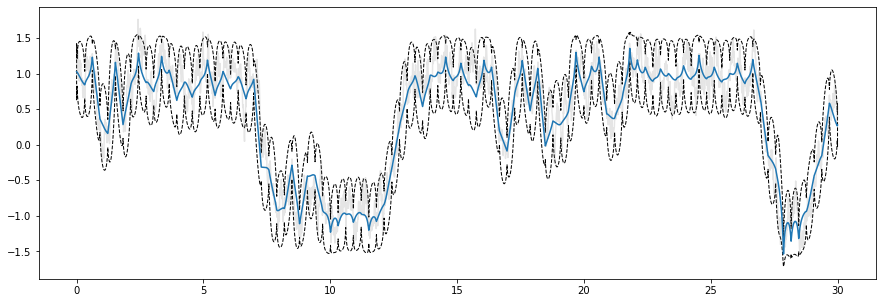

In [14]:
plt.rcParams["figure.figsize"] = [15, 5]
plt.plot(time_grid, tf.reshape(latent_process, (-1)), label="Latent Process", alpha=0.2, color="gray")

plt.plot(time_grid, ssm_model.fx_mus.numpy().reshape(-1))
plt.fill_between(
            time_grid,
            y1=(ssm_model.fx_mus.numpy().reshape(-1) - 2 * np.sqrt(ssm_model.fx_covs.numpy().reshape(-1))),
            y2=(ssm_model.fx_mus.numpy().reshape(-1) + 2 * np.sqrt(ssm_model.fx_covs.numpy().reshape(-1))),
            edgecolor="black",
            facecolor=(0, 0, 0, 0.),
            linestyle='dashed'
        )

In [15]:
ssm_lin_prior_marginals = ssm_model.dist_p_ssm.marginals

ssm_lin_prior_m = ssm_lin_prior_marginals[0].numpy().reshape(-1)
ssm_lin_prior_S = ssm_lin_prior_marginals[1].numpy().reshape(-1)

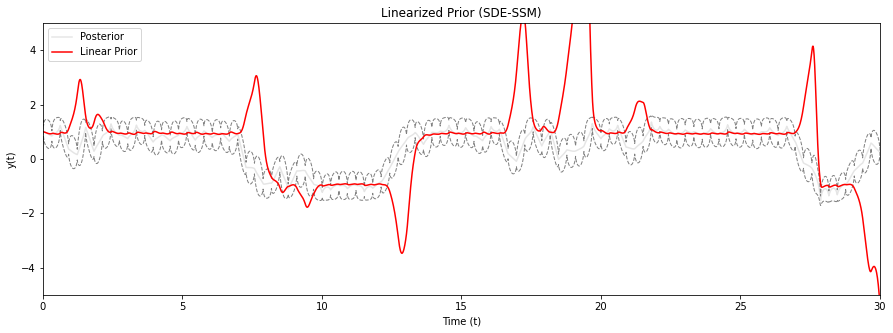

In [17]:
plt.rcParams["figure.figsize"] = [15, 5]

plt.plot(time_grid, ssm_model.fx_mus.numpy().reshape(-1), label="Posterior", alpha=0.2, color="gray")
plt.fill_between(
            time_grid,
            y1=(ssm_model.fx_mus.numpy().reshape(-1) - 2 * np.sqrt(ssm_model.fx_covs.numpy().reshape(-1))),
            y2=(ssm_model.fx_mus.numpy().reshape(-1) + 2 * np.sqrt(ssm_model.fx_covs.numpy().reshape(-1))),
            edgecolor="gray",
            facecolor=(0, 0, 0, 0.),
            linestyle='dashed'
        )


plt.plot(time_grid, ssm_lin_prior_m, label="Linear Prior", color="red")



plt.xlabel("Time (t)")
plt.ylabel("y(t)")
plt.xlim([t0, t1])
plt.ylim([-5 ,5])
plt.title("Linearized Prior (SDE-SSM)")
plt.legend()
plt.show()